In [47]:
import copy
import numpy as np
import pfea.solver as ksolver
import cvxopt
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.spatial import cKDTree 
import itertools

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection


import sympy
from matplotlib.lines import Line2D

# Multiscale Stiffness Method

Vigliotti and Pasini introduced a method that allows one to generalize the stiffness of an arbitrary macroscopic cellular solid from the stiffness matrix of its unit cell.

## Strain Displacement Model

We first want to relate a macroscopic strain field to a deformation of the unit cell. The change in a unit cell vector as a function of the macroscopic strain field is as follows:

$$
\begin{bmatrix}
    \Delta a_x\\
    \Delta a_y\\
    \Delta a_z
\end{bmatrix} = 
\begin{bmatrix}
    a_x &   0 &   0 & \frac{a_y}{2} &            0  & \frac{a_z}{2} \\
      0 & a_y &   0 & \frac{a_x}{2} & \frac{a_z}{2} &            0  \\
      0 &   0 & a_z &            0  & \frac{a_y}{2} & \frac{a_x}{2} 
\end{bmatrix}
\begin{bmatrix}
    \epsilon_x\\
    \epsilon_y\\
    \epsilon_z\\
    \gamma_{yz}\\
    \gamma_{zx}\\
    \gamma_{xy}
\end{bmatrix}
$$

The equations for all periodic vectors can be grouped into a single matrix $B_{\epsilon}$

$$
\vec{\Delta a} = \textbf{B}_{\epsilon}\vec{\epsilon}_M \textrm{  with  }
\textbf{B}_{\epsilon} = 
\begin{bmatrix}
    a_{1x} &      0 &      0 & \frac{a_{1y}}{2} &               0  & \frac{a_{1z}}{2} \\
         0 & a_{1y} &      0 & \frac{a_{1x}}{2} & \frac{a_{1z}}{2} &               0  \\
         0 &      0 & a_{1z} &               0  & \frac{a_{1y}}{2} & \frac{a_{1x}}{2} \\
    a_{2x} &      0 &      0 & \frac{a_{2y}}{2} &               0  & \frac{a_{2z}}{2} \\
         0 & a_{2y} &      0 & \frac{a_{2x}}{2} & \frac{a_{2z}}{2} &               0  \\
         0 &      0 & a_{2z} &               0  & \frac{a_{2y}}{2} & \frac{a_{2x}}{2} \\
    a_{3x} &      0 &      0 & \frac{a_{3y}}{2} &               0  & \frac{a_{3z}}{2} \\
         0 & a_{3y} &      0 & \frac{a_{3x}}{2} & \frac{a_{3z}}{2} &               0  \\
         0 &      0 & a_{3z} &               0  & \frac{a_{3y}}{2} & \frac{a_{3x}}{2} 
\end{bmatrix}
$$

The unit vectors in a cubic unit cell are

$$
    \vec{a}_{1} = \{1\,,0\,,0\}\\
    \vec{a}_{2} = \{0\,,1\,,0\}\\
    \vec{a}_{3} = \{0\,,0\,,1\}
$$

therefore the value for $\textbf{B}_{\epsilon}$ is as follows:

In [2]:
Be = np.zeros((9,6))
Be[0][0] = 1.0
Be[4][1] = 1.0
Be[8][2] = 1.0
Be[1][3] = 0.5
Be[2][5] = 0.5
Be[3][3] = 0.5
Be[5][4] = 0.5
Be[6][5] = 0.5
Be[7][4] = 0.5

Be

array([[1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5],
       [0. , 0. , 0. , 0.5, 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5],
       [0. , 0. , 0. , 0. , 0.5, 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. ]])

## Representing the Nodes

There are fourteen nodes in a single face centered cubic unit cell. However, due to periodic boundary conditions, these fourteen nodes can be simplified down to four independent nodes which can then be related to the rest through a linear combination of the unit cell vectors we described earlier. 

Using block matrices, this relationship looks like

$$
\textbf{d} = \textbf{B}_0\textbf{d}_0+\textbf{B}_a\vec{\Delta a}
$$

Where:
 * $\textbf{d}$ is a block array collecting the DoFs of all the nodes of a unit cell.
 * $\textbf{B}_0$ expresses the dependencies among the nodes of the unit cell in relation to the periodic vectors; it has as many row blocks as the number of nodes of the unit cell and as many column blocks as the numbers of independent nodes; for each row only one column block is non zero; the blocks are identity matrices of the size of the number of DoFs for each node.
 * $\textbf{d}_0$ is an array collecting the DoFs of the independent nodes.
 * $\textbf{B}_a$ expresses the relative displacement between corresponding boundary nodes of the unit cells, as a function of the change in the periodic vectors; it has as many row blocks as the number of nodes of the unit cell; it has also as many column blocks as the number of independent periodic vectors; the blocks are signed to take into account negative translations

The four independent nodes (and their dependent periodic equivalents):

  1. A node located at $\{0,\,0,\,0\}$, which is also present at the seven other corners of the cube through periodic conditions (i.e. $\{1.0,\,0,\,0\}$, $\{0,\,1.0,\,0\}$, ... , $\{1.0,\,0,\,1.0\}$, and $\{1.0,\,1.0,\,1.0\}$)
  2. A node located at $\{0,\,0.5,\,0.5\}$, which is also located at $\{1.0,\,0.5,\,0.5\}$
  2. A node located at $\{0.5,\,0,\,0.5\}$, which is also located at $\{0.5,\,1.0,\,0.5\}$
  2. A node located at $\{0.5,\,0.5,\,0\}$, which is also located at $\{0.5,\,0.5,\,1.0\}$
  
Numbering according to the scheme proposed in Frame3dd (increasing $z$, then $y$, then $x$), we get the ordering as follows:

<img src="media/fcc_nodes.png" alt="drawing" width="400"/>


As a result, nodes 1, 3, 6, and 7 are independent, and the other 10 can be represented as the sum of these nodes and a linear combination of the unit cell vectors. The values for $\textbf{d}$, $\textbf{B}_0$, $\textbf{d}_0$, $\textbf{B}_a$, and $\vec{\Delta a}$ are therefore as follows:
$$
\textbf{d} = 
\begin{bmatrix}
    \textbf{d}_1 \\ \textbf{d}_2 \\ \textbf{d}_3 \\ \textbf{d}_4 \\ \textbf{d}_5 \\ \textbf{d}_6 \\
    \textbf{d}_7 \\ \textbf{d}_8 \\ \textbf{d}_9 \\ \textbf{d}_{10} \\ \textbf{d}_{11} \\ \textbf{d}_{12}\\
    \textbf{d}_{13} \\ \textbf{d}_{14}
\end{bmatrix} \,\,
\textbf{B}_0 = \begin{bmatrix}
\textbf{I} & \textbf{0} & \textbf{0} & \textbf{0} \\
\textbf{I} & \textbf{0} & \textbf{0} & \textbf{0} \\
\textbf{0} & \textbf{I} & \textbf{0} & \textbf{0} \\
\textbf{I} & \textbf{0} & \textbf{0} & \textbf{0} \\
\textbf{I} & \textbf{0} & \textbf{0} & \textbf{0} \\
\textbf{0} & \textbf{0} & \textbf{I} & \textbf{0} \\
\textbf{0} & \textbf{0} & \textbf{0} & \textbf{I} \\
\textbf{0} & \textbf{0} & \textbf{0} & \textbf{I} \\
\textbf{0} & \textbf{0} & \textbf{I} & \textbf{0} \\
\textbf{I} & \textbf{0} & \textbf{0} & \textbf{0} \\
\textbf{I} & \textbf{0} & \textbf{0} & \textbf{0} \\
\textbf{0} & \textbf{I} & \textbf{0} & \textbf{0} \\
\textbf{I} & \textbf{0} & \textbf{0} & \textbf{0} \\
\textbf{I} & \textbf{0} & \textbf{0} & \textbf{0} \\
\end{bmatrix}\,\,
\textbf{d}_0 = 
\begin{bmatrix}
\textbf{d}_1 \\ \textbf{d}_2 \\ \textbf{d}_3 \\ \textbf{d}_4
\end{bmatrix}\,\,
\textbf{B}_a = \begin{bmatrix}
\textbf{0}   & \textbf{0}   & \textbf{0} \\
\textbf{0}   & \textbf{0}   & \textbf{I}_t\\
\textbf{0}   & \textbf{0}   & \textbf{0} \\
\textbf{0}   & \textbf{I}_t & \textbf{0} \\
\textbf{0}   & \textbf{I}_t & \textbf{I}_t\\
\textbf{0}   & \textbf{0}   & \textbf{0} \\
\textbf{0}   & \textbf{0}   & \textbf{0} \\
\textbf{0}   & \textbf{0}   & \textbf{I}_t\\
\textbf{0}   & \textbf{I}_t & \textbf{0}\\
\textbf{I}_t & \textbf{0}   & \textbf{0} \\
\textbf{I}_t & \textbf{0}   & \textbf{I}_t\\
\textbf{I}_t & \textbf{0}   & \textbf{0} \\
\textbf{I}_t & \textbf{I}_t & \textbf{0} \\
\textbf{I}_t & \textbf{I}_t & \textbf{I}_t \\
\end{bmatrix}\,\,
\vec{\Delta a} = 
\begin{bmatrix}
\vec{\Delta a_1} \\ \vec{\Delta a_2} \\ \vec{\Delta a_3}
\end{bmatrix}
$$

The simplest way to encapsulate these block matrices is to simply specify the coordinates of the identity matrices for $\textbf{B}_0$ and $\textbf{B}_a$. For $\textbf{B}_0$, it is enough to specify which column has the identity matrix for each row, since each row will need an identity. For $\textbf{B}_a$, we instead specify the list of columns that will have a transform. We do this in the next block of code.

In [3]:

B_0_coords = [0,0,1,0,0,2,3,3,2,0,0,1,0,0]
B_a_coords = [[],[2],[],[1],[1,2],[],[],[2],[1],[0],[0,2],[0],[0,1],[0,1,2]]

fcc_B_0 = np.zeros((84,24))

for row,col in enumerate(B_0_coords):
    for i in range(6):
        fcc_B_0[row*6+i][col*6+i] = 1.0

fcc_B_a = np.zeros((84,9))

for row,cols in enumerate(B_a_coords):
    for col in cols:
        for i in range(3):
            fcc_B_a[row*6+i][col*3+i] = 1.0
            
kel_B_0_coords = [ 0, 1, 2, 3, 4, 5, 5, 4, 6, 7, 8, 8, 9, 9, 6, 7,10,11,11,10, 0, 1, 2, 3]
kel_B_a_coords = [[],[],[],[],[],[],[2],[1],[],[],[],[2],[],[2],[1],[1],[],[],[2],[1],[0],[0],[0],[0]]

kel_B_0 = np.zeros((144,72))

for row,col in enumerate(kel_B_0_coords):
    for i in range(6):
        kel_B_0[row*6+i][col*6+i] = 1.0

kel_B_a = np.zeros((144,9))

for row,cols in enumerate(kel_B_a_coords):
    for col in cols:
        for i in range(3):
            kel_B_a[row*6+i][col*3+i] = 1.0
            
psch_B_0_coords = [ 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 4,10,11,12,12,13,13,10,11,14,15,16,17,17,18,19,14, 0, 1, 2, 3]

psch_B_a_coords = [[],[],[],[],[],[],[],[],
                  [2],[],[],[1],[],[],[],[2],
                  [],[2],[1],[1],[],[],[],[],
                  [2],[],[],[1],[0],[0],[0],[0]]

psch_B_0 = np.zeros((192,120))

for row,col in enumerate(psch_B_0_coords):
    for i in range(6):
        psch_B_0[row*6+i][col*6+i] = 1.0

psch_B_a = np.zeros((192,9))

for row,cols in enumerate(psch_B_a_coords):
    for col in cols:
        for i in range(3):
            psch_B_a[row*6+i][col*3+i] = 1.0

CO_B_0_coords = [ 0, 1, 2, 3,
               4, 5, 6, 7, 6, 8, 9,10,11,10, 4, 5,
              12,13,14,15,
              16,17,18,19,18,20,21,22,23,22,16,17,
               0, 1, 2, 3]
CO_B_a_coords = [[],[],[],[],
              [],[],[],[],[2],[],[],[],[],[2],[1],[1],
              [],[],[],[],
              [],[],[],[],[2],[],[],[],[],[2],[1],[1],
              [0],[0],[0],[0]]

CO_B_0 = np.zeros((len(CO_B_0_coords)*6,(max(CO_B_0_coords)+1)*6))

for row,col in enumerate(CO_B_0_coords):
    for i in range(6):
        CO_B_0[row*6+i][col*6+i] = 1.0

CO_B_a = np.zeros((len(CO_B_0_coords)*6,9))

for row,cols in enumerate(CO_B_a_coords):
    for col in cols:
        for i in range(3):
            CO_B_a[row*6+i][col*3+i] = 1.0

In [4]:
#14 nodes in total
def gen_dsch_nodes(offset):
    return[[0.0,0.0,0.0],
           [0.0,0.0,1.0],
           [0.0,0.5+offset,0.5+offset],
           [0.0,1.0,0.0],
           [0.0,1.0,1.0],
           [0.5+offset,0.0,0.5+offset],
           [0.5+offset,0.5+offset,0.0],
           [0.5+offset,0.5+offset,1.0],
           [0.5+offset,1.0,0.5+offset],
           [1.0,0.0,0.0],
           [1.0,0.0,1.0],
           [1.0,0.5+offset,0.5+offset],
           [1.0,1.0,0.0],
           [1.0,1.0,1.0]]

def gen_kel_nodes(angle):
    assert angle >= 0 and angle < np.pi/2.
    l = 1.0/(2*np.sqrt(2))
    return [[0.00,0.50-l*np.sin(angle),0.50],
            [0.00,0.50,0.50-l*np.cos(angle)],
            [0.00,0.50,0.50+l*np.cos(angle)],
            [0.00,0.50+l*np.sin(angle),0.50],
            [0.5-l*np.cos(angle),0.00,0.50],
            [0.5-l*np.sin(angle),0.50,0.00],
            [0.5-l*np.sin(angle),0.50,1.00],
            [0.5-l*np.cos(angle),1.00,0.50],
            [0.50,0.00,0.5-l*np.sin(angle)],
            [0.50,0.00,0.5+l*np.sin(angle)],
            [0.50,0.5-l*np.cos(angle),0.00],
            [0.50,0.5-l*np.cos(angle),1.00],
            [0.50,0.5+l*np.cos(angle),0.00],
            [0.50,0.5+l*np.cos(angle),1.00],
            [0.50,1.00,0.5-l*np.sin(angle)],
            [0.50,1.00,0.5+l*np.sin(angle)],
            [0.5+l*np.cos(angle),0.00,0.50],
            [0.5+l*np.sin(angle),0.50,0.00],
            [0.5+l*np.sin(angle),0.50,1.00],
            [0.5+l*np.cos(angle),1.00,0.50], 
            [1.00,0.50-l*np.sin(angle),0.50],
            [1.00,0.50,0.50-l*np.cos(angle)],
            [1.00,0.50,0.50+l*np.cos(angle)],
            [1.00,0.50+l*np.sin(angle),0.50]]

def gen_psch_nodes(offset):
    return [[0.00,0.25,0.50],[0.00,0.50,0.25],[0.00,0.50,0.75],[0.00,0.75,0.50],
            [0.25,0.00,0.50],[0.25+offset,0.25+offset,0.25+offset],[0.25+offset,0.25+offset,0.75-offset],[0.25,0.50,0.00],
            [0.25,0.50,1.00],[0.25+offset,0.75-offset,0.25+offset],[0.25+offset,0.75-offset,0.75-offset],[0.25,1.00,0.50],
            [0.50,0.00,0.25],[0.50,0.00,0.75],[0.50,0.25,0.00],[0.50,0.25,1.00],
            [0.50,0.75,0.00],[0.50,0.75,1.00],[0.50,1.00,0.25],[0.50,1.00,0.75],
            [0.75,0.00,0.50],[0.75-offset,0.25+offset,0.25+offset],[0.75-offset,0.25+offset,0.75-offset],[0.75,0.50,0.00],
            [0.75,0.50,1.00],[0.75-offset,0.75-offset,0.25+offset],[0.75-offset,0.75-offset,0.75-offset],[0.75,1.00,0.50],
            [1.00,0.25,0.50],[1.00,0.50,0.25],[1.00,0.50,0.75],[1.00,0.75,0.50]]

def psch_beamlength(offset):
    return np.linalg.norm(np.array([0.00,0.25,0.50])-np.array([0.25+offset,0.25+offset,0.25+offset]))

In [5]:
d,e = sympy.symbols('d e')
x1 = np.array([0.25-d, 0, 0.25+d])
x2 = np.array([0.25+d, 0.25-d, 0.5])

print(np.sum(np.power(x2-x1,2)).simplify())

strain = 0.1

np.roots([6.0,-1.0,0.125-np.power((strain+1)/(2*np.sqrt(2)),2)])

6.0*d**2 - 1.0*d + 0.125


array([ 0.18972621, -0.02305954])

In [6]:
octet_frames = [[ 1, 3],[ 1, 6],[ 1, 7],[ 2, 3],[ 2, 6],[ 3, 4],
                [ 3, 5],[ 3, 6],[ 3, 7],[ 3, 8],[ 3, 9],[ 4, 7],
                [ 6, 7],[ 6, 8],[ 6,10],[ 6,11],[ 6,12],[ 7, 9],
                [ 7,10],[ 7,12],[ 7,13],[ 8, 9],[ 8,12],[ 9,12]]
octet_frames = np.array(octet_frames)-1

fcc_frames   = [[ 1, 3],[ 1, 6],
                [ 1, 7],[ 2, 3],[ 2, 6],[ 3, 4],
                [ 3, 5],[ 4, 7],[ 6,10],[ 6,11],
                [ 7,10],[ 7,13]]
fcc_frames = np.array(fcc_frames)-1

dsch_frames  = np.array([[ 1, 2],[ 1, 5],[ 2, 3],[ 2, 7],[ 2, 8],[ 3, 6],
                [ 5, 7],[ 5, 9],[ 5,11],[ 6, 8],[ 6, 9],[ 6,11]])

dsch_ss = [ 1,-1,-1,-1, 1, 1, 1, 1,-1,-1,-1, 1]

kelvin_frames = [[ 1, 2],[ 1, 3],[ 1, 5],[ 2, 4],[ 2, 6],[ 3, 4],
                 [ 3, 7],[ 4, 8],[ 5, 9],[ 5,10],[ 6,11],[ 6,13],
                 [ 9,11],[ 9,17],[10,12],[10,17],[11,18],[13,15],
                 [13,18],[14,16],[17,21],[18,22],[19,23],[20,24]]
kelvin_frames = np.array(kelvin_frames)-1

psch_frames = [[ 1, 6],[ 1, 7],[ 2, 6],[ 2,10],[ 3, 7],[ 3,11],[ 4,10],[ 4,11],
               [ 5, 6],[ 5, 7],[ 6, 8],[ 6,13],[ 6,15],[ 7, 9],[ 7,14],[ 7,16],
               [ 8,10],[ 9,11],[10,12],[10,17],[10,19],[11,12],[11,18],[11,20],
               [13,22],[14,23],[15,22],[16,23],[17,26],[18,27],[19,26],[20,27],
               [21,22],[21,23],[22,24],[22,29],[22,30],[23,25],[23,29],[23,31],
               [24,26],[25,27],[26,28],[26,30],[26,32],[27,28],[27,31],[27,32]]

psch_frames = np.array(psch_frames)-1

co_frames = [[ 0, 4], [ 0, 6], [ 0, 7], [ 0, 9],
             [ 1, 5], [ 1, 7], [ 1, 8], [ 1,10], 
             [ 2, 9], [ 2,11], [ 2,12], [ 2,14], 
             [ 3,10], [ 3,12], [ 3,13], [ 3,15], 
             [ 4, 6], [ 4, 7], [ 4,16], 
             [ 5, 7], [ 5, 8], [ 5,17], 
             [ 6, 9], [ 6,16], 
             [ 7, 9], [ 7,10], [ 7,16], [ 7,17], 
             [ 8,10], [ 8,17], 
             [ 9,11], [ 9,12], [ 9,16], [ 9,18], 
             [10,12], [10,13], [10,17], [10,19], 
             [11,14], [11,18], 
             [12,14], [12,15], [12,18], [12,19],
             [13,15], [13,19], 
             [14,18], 
             [15,19], 
             [16,20], [16,22], [16,23], [16,25], 
             [17,21], [17,23], [17,24], [17,26], 
             [18,25], [18,27], [18,28], [18,30], 
             [19,26], [19,28], [19,29], [19,31], 
             [20,22], [20,23], [20,32], 
             [21,23], [21,24], [21,33], 
             [22,25], [22,32], 
             [23,25], [23,26], [23,32], [23,33], 
             [24,26], [24,33], 
             [25,27], [25,28], [25,32], [25,34], 
             [26,28], [26,29], [26,33], [26,35], 
             [27,30], [27,34], 
             [28,30], [28,31], [28,34], [28,35], 
             [29,31], [29,35], 
             [30,34], 
             [31,35]]

co_frames = np.array(co_frames)

co_a1u_self_stress = np.array([-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,1,-1,-1,
                               -1,-1,1,1,-1,-1,1,-1,1,1,1,1,-1,1,-1,1,1,1,1,
                               1,1,1,-1,1,1,-1,1,1,-1,-1,-1,1,-1,1,1,1,1,1,
                               -1,1,1,-1,1,1,1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,
                               1,1,-1,1,1,-1,1,1,1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,-1,-1,-1,-1])

co_a2u_self_stress = np.array([1,1,-1,-1,-1,1,-1,1,1,-1,1,-1,-1,-1,1,1,1,-1,
                               -1,1,-1,1,-1,-1,1,-1,1,-1,1,1,1,-1,1,-1,1,-1,
                               -1,1,-1,1,1,-1,-1,1,1,-1,1,-1,1,1,-1,-1,-1,1,
                               -1,1,1,-1,1,-1,-1,-1,1,1,-1,1,-1,-1,1,1,1,-1,
                               -1,1,1,-1,-1,1,-1,1,1,-1,-1,1,-1,1,1,1,-1,1,-1,1,-1,-1,1,-1])


In [39]:
def lattice_stiffness(nodes, frameset, unitcell_dims, beamlength, relative_density, B_0, B_a, strain = {}):
    E_mat = 2.1e9
    rho_mat = 1.0
    nu_mat = 0.3

    frame_props = {'E'   : E_mat,
                   'rho' : rho_mat,
                   'nu'  : nu_mat,
        'cross_section'  : 'circular',
                   'roll': 0,
                  'loads':{'element':0},
            'prestresses':{'element':0},
                     'Le': beamlength,
         'beam_divisions': 1,
                  'shear': False,
           'pin-jointed' : False}
    
    Q = np.zeros((len(frameset),12))
    
    try:
        for i in range(len(frameset)):
            Q[i][0] = strain['state'][i]*strain['mag']
    except KeyError:
        Q = np.zeros((len(frameset),12))
        
    global_args = {'dof' : len(nodes)*6,
                   'self_stress' : Q}
    
    
    beam_diameter = 2.0*np.sqrt(relative_density*unitcell_dims**3/(frameset.shape[0]*np.pi*beamlength))
    
    t_frame_props = copy.copy(frame_props)
    t_frame_props['d1'] = beam_diameter
    t_frame_props['d2'] = beam_diameter
    t_frame_props['th'] = beam_diameter/2.0
    
    tt_frame_props = copy.copy(t_frame_props)
    tt_frame_props['pin-jointed'] = True
        
    out_frames = [(frameset,np.zeros((0,len(frameset))),t_frame_props)]
    pj_out_frames = [(frameset,np.zeros((0,len(frameset))),tt_frame_props)]
    
    
    pjK_uc = ksolver.provide_K(nodes, global_args, pj_out_frames)
    
    K_uc = ksolver.provide_K(nodes, global_args, out_frames)
    
    rjK_uc = copy.copy(K_uc)
    #print(np.size(K_uc))
    #print((K_uc)[:6,:])
    tk_uc = np.zeros((global_args['dof'],global_args['dof']))
    for i,col in enumerate(K_uc.I):
        tk_uc[K_uc.J[i]][col] = K_uc[col*global_args['dof']+K_uc.J[i]]
    K_uc = tk_uc

    D_0 = -1*np.dot(np.linalg.pinv(np.dot(B_0.T,np.dot(K_uc,B_0))),np.dot(B_0.T,np.dot(K_uc,B_a)))

    D_a = np.dot(B_0,D_0)+B_a

    K_da = np.dot(D_a.T,np.dot(K_uc,D_a))

    Ke = 1.0/(unitcell_dims**3)*np.dot(Be.T,np.dot(K_da,Be))
    
    w,v = np.linalg.eig(Ke)
    sw = np.sort(w)[::-1]
    
    #print(frame_names[frame_index])    
    #print('==============================')
    #print('Eigenvalues:\n\t '+' '.join(['{:>6.6f}'.format(item) for item in sw])+'\n')
    #print('\n')
    evals = np.zeros(3)
    
    #print(np.real(sw)/E_mat/relative_density)
    
    test = np.real(sw)/E_mat/relative_density
    
    #print(np.round(np.real(sw)/E_mat/relative_density,8))
    evals = np.array([sw[0],sw[1],sw[3]])
    if not frame_props['pin-jointed']:
        for i in range(len(sw)):
            evals[int(np.sum(np.abs(test-test[i])<1e-12))-1] = sw[i]
    else:
        evals = np.array([sw[0],sw[1],sw[3]])
    #if not frame_props['pin-jointed']:
        #print(sw)
        
        #print(evals)
    #else:
        #evals = np.array([sw[0],sw[1],sw[3]])
    
    tform = np.array([[ 1, 2, 0],
                      [ 1,-1, 0],
                      [ 0, 0, 1]])

    base = np.dot(np.linalg.inv(tform),evals)/relative_density/E_mat#(frameset.shape[0]*E_mat*np.pi*(beam_diameter/2.0)**2)*beamlength**2

    #print('Kmat:\n\t'+'\n\t'.join([' '.join(['{:>6.3f}'.format(item) for item in row]) 
      #for row in Ke/E_mat/relative_density]))
    #print(base*relative_density)
    compliance = np.linalg.inv(Ke)*E_mat*relative_density
    #print('\nCompliance:\n\t '+'\n\t'.join([' '.join(['{:>6.3f}'.format(item) for item in row]) 
     # for row in compliance]))
    '''
    print('\nCoefficients:')
    print("\t Alpha: {0:6.6f}".format(base[0])) #*frame_props["Le"]**2/frame_props["d1"]**2))#np.dot(np.linalg.inv(tform),evals))
    print("\t  Beta: {0:6.6f}".format(base[1])) #*frame_props["Le"]**2/frame_props["d1"]**2))
    print("\t Gamma: {0:6.6f}".format(base[2])) #*frame_props["Le"]**2/frame_props["d1"]**2))
    
    print('\nEigenvalues:')
    print("\tHydrostatic: {0:6.6f}".format(evals[0]/E_mat/relative_density))#np.dot(np.linalg.inv(tform),evals))
    print("\t Deviatoric: {0:6.6f}".format(evals[1]/E_mat/relative_density))
    print("\t      Shear: {0:6.6f}".format(evals[2]/E_mat/relative_density))

    print("\n")
    '''
    return np.array(cvxopt.matrix(rjK_uc)), evals/E_mat/relative_density



In [37]:
strain = 0.001
relden = 0.1

print("-------DSCHWARZ-------")

nodes, bars, self_stress, B_0, B_a = DSCH_A2u_LSM(DSCH_offset_from_strain(-strain))
nodes = nodes*(1-strain)
dsch_strain = {'state':self_stress,'mag':0}
bd,eigens = lattice_stiffness(nodes, bars, 1-strain, 0.5*np.sqrt(2),relden,B_0, B_a,strain=dsch_strain)

#print(eigens)

nodes, bars, self_stress, B_0, B_a = DSCH_A2u_LSM(DSCH_offset_from_strain(-strain))

nodes = nodes*(1-strain)
dsch_strain = {'state':self_stress,'mag':2.1e9*strain*relden*np.power(1-strain,3)/(len(bars)*0.5)}
bd,eigens = lattice_stiffness(nodes, bars, 1-strain, 0.5*np.sqrt(2),relden,B_0, B_a,strain=dsch_strain)
#print(eigens)

print("\n\n-------CUBOCT-------")

nodes, bars, self_stress, B_0, B_a = CO_A2g_LSM(CO_theta_from_strain(-strain))
nodes = nodes*(1-strain)
co_strain = {'state':self_stress,'mag':0}
bd,eigens = lattice_stiffness(nodes, bars, 1-strain, 0.25*np.sqrt(2),relden,B_0, B_a,strain=co_strain)

print(eigens)

nodes, bars, self_stress, B_0, B_a = CO_A2g_LSM(CO_theta_from_strain(-strain))

nodes = nodes*(1-strain)
co_strain = {'state':self_stress,'mag':2.1e9*strain*relden*np.power(1-strain,3)/(len(bars)*0.125)}
bd,eigens = lattice_stiffness(nodes, bars, 1-strain, 0.25*np.sqrt(2),relden,B_0, B_a,strain=co_strain)
print(eigens)

-------DSCHWARZ-------
[0.30663149 0.08479935 0.08479935 0.08086178 0.08086178 0.08086178]
[0.30662909 0.08479916 0.08479916 0.08086148 0.08086148 0.08086148]


-------CUBOCT-------
[0.2955149  0.08828439 0.08828439 0.08440917 0.08440917 0.08440917]
[0.2955149  0.08828439 0.08440917]
[0.2958425  0.08832106 0.08822226 0.08444576 0.08441649 0.08436151]
[0.08436151 0.08832106 0.08444576]


In [29]:
#Methods for transforming the octahedron.

#mirror planes, defined by norm (needs to be of length 1) and offset (can be anything)
def mir(tnodes, tbars, norm=(0,0,1),offset=(0,0,0)):
    norm = np.array(norm)/np.linalg.norm(np.array(norm))
    offset = np.dot(norm,np.array(offset))
    reflected_nodes = np.copy(tnodes)
    reflected_nodes = reflected_nodes-offset
    reflected_nodes = reflected_nodes.T
    for i in range(len(norm)):
        if norm[i] != 0:
            reflected_nodes[i] = reflected_nodes[i]*(-norm[i])
    
    reflected_nodes = reflected_nodes.T+offset
    
    return (np.vstack((tnodes,reflected_nodes)), np.vstack((tbars,tbars+np.shape(reflected_nodes)[0])))

def rotate_about_axis(nodes, axis, angle):
    axis = np.array(axis)
    axis = axis/np.linalg.norm(axis)
    a = np.cos(angle/2)
    b = axis[0]*np.sin(angle/2)
    c = axis[1]*np.sin(angle/2)
    d = axis[2]*np.sin(angle/2)
    e_r = np.array([[a**2+b**2-c**2-d**2,         2*(b*c-a*d),         2*(b*d+a*c)],
                    [        2*(b*c+a*d), a**2+c**2-b**2-d**2,         2*(c*d-a*b)],
                    [        2*(b*d-a*c),         2*(c*d+a*b), a**2+d**2-b**2-c**2]])
    return np.array([np.dot(e_r,node) for node in nodes])

def unique_points(a,tol=1e-5,leafsize=10):
    #Use KDTree to do uniqueness check within tolerance.
    pairs = cKDTree(a,leafsize=leafsize).query_pairs(tol)  #pairs of (i,j) where i<j and d(a[i]-a[j])<tol
    components = pairs# map(sorted, nx.connected_components(nx.Graph(data=list(pairs)))) #sorted connected components of the proximity graph
    idx = np.delete( np.arange(np.shape(a)[0]),  list(itertools.chain(*[c[1:] for c in components])) ) #all indices of a, except nodes past first in each component
    inv = np.arange(np.shape(a)[0])
    for c in components: inv[c[1:]]=c[0]
    inv = np.searchsorted(idx,inv)
    return idx,inv

def unique_reduce(tnodes,tbars):
    #reduced_idx,reduced_inv = unique_rows(nodes)
    reduced_idx,reduced_inv = unique_points(tnodes)
    return tnodes[reduced_idx],reduced_inv[tbars]

def CO_base_nodes(theta):
    base_nodes = np.array([[0.0,0.5,0.5],
                           [0.5,0.0,0.5],
                           [0.5,0.5,0.0],
                           [0.5,0.5,1.0],
                           [0.5,1.0,0.5],
                           [1.0,0.5,0.5]])
    base_nodes = rotate_about_axis(base_nodes,[1,1,1],theta)
    return base_nodes

def CO_A2g(theta):
    base_nodes = CO_base_nodes(theta)
    bars = np.array([[0,1],[0,2],[0,3],[0,4],
                     [1,2],[1,3],[1,5],
                     [2,4],[2,5],
                     [3,4],[3,5],
                     [4,5]])
    ret_nodes,ret_bars = mir(base_nodes, bars,norm=(0,0,1),offset=(0,0,base_nodes[3][2]))
    ret_nodes,ret_bars = mir(ret_nodes, ret_bars,norm=(0,1,0),offset=(0,base_nodes[4][1],0))
    ret_nodes,ret_bars = mir(ret_nodes, ret_bars,norm=(1,0,0),offset=(base_nodes[5][0],0,0))
    rot_nodes, rot_bars = unique_reduce(ret_nodes,ret_bars)
    
    rot_nodes = np.round(rot_nodes,8)
    rot_ind = np.lexsort((rot_nodes.T[2],rot_nodes.T[1],rot_nodes.T[0]))
    ind_of_rot_ind = np.argsort(rot_ind)
    
    new_rot_bars = []
    for bar in rot_bars:
        new_rot_bars.append([ind_of_rot_ind[bar[0]],ind_of_rot_ind[bar[1]]])
    
    new_rot_bars = np.array(new_rot_bars)
    bar_ind = np.lexsort((new_rot_bars.T[1],new_rot_bars.T[0]))
    
    co_a1u_self_stress = np.array([-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,1,
                                   -1,-1,-1,-1,1,1,-1,-1,1,-1,1,1,1,1,-1,
                                   1,-1,1,1,1,1,1,1,1,-1,1,1,-1,1,1,-1,-1,
                                   -1,1,-1,1,1,1,1,1,-1,1,1,-1,1,1,1,1,1,
                                   -1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,1,-1,
                                   1,1,1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,-1,-1,-1,-1])
    co_a2u_self_stress = np.array([1,1,-1,-1,-1,1,-1,1,1,-1,1,-1,-1,-1,1,1,1,-1,
                               -1,1,-1,1,-1,-1,1,-1,1,-1,1,1,1,-1,1,-1,1,-1,
                               -1,1,-1,1,1,-1,-1,1,1,-1,1,-1,1,1,-1,-1,-1,1,
                               -1,1,1,-1,1,-1,-1,-1,1,1,-1,1,-1,-1,1,1,1,-1,
                               -1,1,1,-1,-1,1,-1,1,1,-1,-1,1,-1,1,1,1,-1,1,-1,1,-1,-1,1,-1])
    
    full_self_stress = 0.5*(co_a1u_self_stress+co_a2u_self_stress)
    return 0.5*rot_nodes[rot_ind],new_rot_bars[bar_ind],full_self_stress[bar_ind]


def CO_A2g_LSM(theta):
    aux_nodes, aux_bars, aux_ss = CO_A2g(theta)

    B_0, B_a = gen_B_matrices_from_nodes(aux_nodes)
    
    return aux_nodes, aux_bars, aux_ss, B_0, B_a
    
def CO_theta_from_strain(strain):
    strain = strain+1
    return 2*np.arcsin(np.sqrt(0.75*(1-strain)))

In [28]:
def DSCH_offset_from_strain(strain):
    l_old = 0.5*np.sqrt(2)
    return 1/np.sqrt(2)*l_old*np.sqrt(np.power(1/(strain+1),2)-1)
    
def DSCH_base_nodes(offset):
    return np.array([[0.0,0.0,0.0],
                     [0.0,0.0,1.0],
                     [0.0,0.5+offset,0.5+offset],
                     [0.0,1.0,0.0],
                     [0.0,1.0,1.0],
                     [0.5+offset,0.0,0.5+offset],
                     [0.5+offset,0.5+offset,0.0],
                     [0.5+offset,0.5+offset,1.0],
                     [0.5+offset,1.0,0.5+offset],
                     [1.0,0.0,0.0],
                     [1.0,0.0,1.0],
                     [1.0,0.5+offset,0.5+offset],
                     [1.0,1.0,0.0],
                     [1.0,1.0,1.0]])

def DSCH_A2u(offset):
    base_nodes = DSCH_base_nodes(offset)
    bars = np.array([[ 1, 2],[ 1, 5],[ 2, 3],[ 2, 7],[ 2, 8],[ 3, 6],
                     [ 5, 7],[ 5, 9],[ 5,11],[ 6, 8],[ 6, 9],[ 6,11]])
    
    base_nodes = np.round(base_nodes,8)
    off_ind = np.lexsort((base_nodes.T[2],base_nodes.T[1],base_nodes.T[0]))
    ind_of_off_ind = np.argsort(off_ind)
    
    new_bars = []
    for bar in bars:
        new_bars.append([ind_of_off_ind[bar[0]],ind_of_off_ind[bar[1]]])
    
    new_bars = np.array(new_bars)
    bar_ind = np.lexsort((new_bars.T[1],new_bars.T[0]))
    dsch_ss = np.array([ 1,-1,-1,-1, 1, 1, 1, 1,-1,-1,-1, 1])
    
    
    return base_nodes[off_ind],new_bars[bar_ind],dsch_ss[bar_ind]

def DSCH_A2u_LSM(offset):
    aux_nodes, aux_bars, aux_ss = DSCH_A2u(offset)

    B_0, B_a = gen_B_matrices_from_nodes(aux_nodes)
    
    return aux_nodes, aux_bars, aux_ss, B_0, B_a

nodes, bars, self_stress, B_0, B_a = DSCH_A2u_LSM(DSCH_offset_from_strain(-0.1))

print(nodes[bars[0][0]],nodes[bars[0][1]])
print((0.5*np.sqrt(2))/np.linalg.norm(nodes[bars[0][0]]-nodes[bars[0][1]]))

[0. 0. 1.] [0.         0.74216105 0.74216105]
0.9000000017081046


In [27]:
def PSCH_offset_from_strain(strain):
    l_old = 0.25*np.sqrt(2)
    return 1/np.sqrt(3)*l_old*np.sqrt(np.power(1/(strain+1),2)-1)

def PSCH_base_nodes(offset):
    return np.array([[0.00,0.25,0.50],[0.00,0.50,0.25],[0.00,0.50,0.75],[0.00,0.75,0.50],
                     [0.25,0.00,0.50],[0.25+offset,0.25+offset,0.25+offset],[0.25+offset,0.25+offset,0.75-offset],[0.25,0.50,0.00],
                     [0.25,0.50,1.00],[0.25+offset,0.75-offset,0.25+offset],[0.25+offset,0.75-offset,0.75-offset],[0.25,1.00,0.50],
                     [0.50,0.00,0.25],[0.50,0.00,0.75],[0.50,0.25,0.00],[0.50,0.25,1.00],
                     [0.50,0.75,0.00],[0.50,0.75,1.00],[0.50,1.00,0.25],[0.50,1.00,0.75],
                     [0.75,0.00,0.50],[0.75-offset,0.25+offset,0.25+offset],[0.75-offset,0.25+offset,0.75-offset],[0.75,0.50,0.00],
                     [0.75,0.50,1.00],[0.75-offset,0.75-offset,0.25+offset],[0.75-offset,0.75-offset,0.75-offset],[0.75,1.00,0.50],
                     [1.00,0.25,0.50],[1.00,0.50,0.25],[1.00,0.50,0.75],[1.00,0.75,0.50]])

def PSCH_A1g(offset):
    base_nodes = PSCH_base_nodes(offset)
    psch_frames = [[ 1, 6],[ 1, 7],[ 2, 6],[ 2,10],[ 3, 7],[ 3,11],[ 4,10],[ 4,11],
                   [ 5, 6],[ 5, 7],[ 6, 8],[ 6,13],[ 6,15],[ 7, 9],[ 7,14],[ 7,16],
                   [ 8,10],[ 9,11],[10,12],[10,17],[10,19],[11,12],[11,18],[11,20],
                   [13,22],[14,23],[15,22],[16,23],[17,26],[18,27],[19,26],[20,27],
                   [21,22],[21,23],[22,24],[22,29],[22,30],[23,25],[23,29],[23,31],
                   [24,26],[25,27],[26,28],[26,30],[26,32],[27,28],[27,31],[27,32]]

    psch_frames = np.array(psch_frames)-1
    
    base_nodes = np.round(base_nodes,8)
    off_ind = np.lexsort((base_nodes.T[2],base_nodes.T[1],base_nodes.T[0]))
    ind_of_off_ind = np.argsort(off_ind)
    
    new_bars = []
    for bar in psch_frames:
        new_bars.append([ind_of_off_ind[bar[0]],ind_of_off_ind[bar[1]]])
    
    new_bars = np.array(new_bars)
    bar_ind = np.lexsort((new_bars.T[1],new_bars.T[0]))
    
    
    return base_nodes[off_ind],new_bars[bar_ind]

def PSCH_A1g_LSM(offset):
    aux_nodes, aux_bars = PSCH_A1g(offset)

    B_0, B_a = gen_B_matrices_from_nodes(aux_nodes)
    
    return aux_nodes, aux_bars, B_0, B_a

nodes, bars, B_0, B_a = PSCH_A1g_LSM(PSCH_offset_from_strain(-0.1))

nodes = nodes*(1-0.1)

print(0.25*np.sqrt(2)/np.linalg.norm(nodes[bars[0][0]]-nodes[bars[0][1]]))

0.9999999916724361


0.9900000000000001


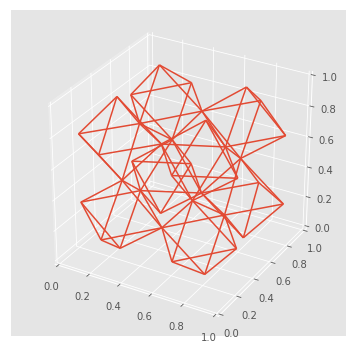

In [26]:
nodes, bars, self_stress, b_0, b_a = CO_A2g_LSM(CO_theta_from_strain(-0.01))

#Testing 1x1x1 plot
print(np.max(nodes.T[0])-np.min(nodes.T[0]))
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')

line_segments = []
for bar in bars:
    line_segments.append([nodes[bar[0]],nodes[bar[1]]])
line_segments = np.array(line_segments)

line_segments = Line3DCollection(line_segments)

ax.add_collection(line_segments)
plt.show()

In [13]:
def gen_B_matrices_from_nodes(nodes):
    maxval = np.max(nodes.T[0])
    minval = np.min(nodes.T[0])

    b_0 = []
    b_a = []
    n = 0
    for node in nodes:
        if (np.abs(node - maxval) < 0.0001).any():
            per_coord = np.array([int(a) for a in np.abs(node - maxval) < 0.0001])
            b_a_row = []
            for i,per_coord_val in enumerate(per_coord):
                if per_coord_val == 1:
                    b_a_row.append(i)
            b_a.append(b_a_row)
            newnode = node-per_coord*(maxval-minval)
            for i,diff in enumerate(nodes-newnode):
                if (np.abs(diff) < 0.0001).all():
                    b_0.append(b_0[i])
                    
        else:
            b_0.append(n)
            b_a.append([])
            n = n+1 

            
    B_0 = np.zeros((len(b_0)*6,(max(b_0)+1)*6))
    B_a = np.zeros((len(b_0)*6,9))
    
    for row,col in enumerate(b_0):
        for i in range(6):
            B_0[row*6+i][col*6+i] = 1.0

    for row,cols in enumerate(b_a):
        for col in cols:
            for i in range(3):
                B_a[row*6+i][col*3+i] = 1.0
    
    return B_0, B_a



In [14]:
nodes, bars, self_stress, B_0, B_a = CO_A2g_LSM(CO_theta_from_strain(0.01))

np.max(nodes.T[0])-np.min(nodes.T[0])
np.linalg.norm(nodes[bars[0][1]]-nodes[bars[0][0]])

nodes, bars,self_stress, B_0, B_a = DSCH_A2u_LSM(DSCH_offset_from_strain(0.001))

print(np.max(nodes.T[0])-np.min(nodes.T[0]))
1/(np.linalg.norm(nodes[bars[0][1]]-nodes[bars[0][0]])/(0.5*np.sqrt(2)))


nan


/Users/dcellucc/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in sqrt
/Users/dcellucc/anaconda3/envs/py37/lib/python3.6/site-packages/numpy-1.15.0-py3.6-macosx-10.7-x86_64.egg/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/dcellucc/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/dcellucc/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


nan

In [44]:
strains = np.power(10,-np.arange(1,5,0.1))
reldens = [0.001,0.1]
co_vals = []
dsch_vals = []
psch_vals = []

for relden in reldens:
    co_val = []
    dsch_val = []
    psch_val = []
    print(relden)
    for strain in strains:
        nodes, bars, self_stress, B_0, B_a = CO_A2g_LSM(CO_theta_from_strain(-strain))
        bd,eigens = lattice_stiffness(nodes, bars, 1-strain, 0.5/np.sqrt(2),relden,B_0, B_a)
        co_val.append(eigens)
        nodes, bars, self_stress, B_0, B_a = DSCH_A2u_LSM(DSCH_offset_from_strain(-strain))
        nodes = nodes*(1-strain)
        bd,eigens = lattice_stiffness(nodes, bars, 1-strain, 0.5*np.sqrt(2),relden,B_0, B_a)
        dsch_val.append(eigens)
        nodes, bars, B_0, B_a = PSCH_A1g_LSM(PSCH_offset_from_strain(-strain))
        nodes = nodes*(1-strain)
        bd,eigens = lattice_stiffness(nodes, bars, 1-strain, 0.25*np.sqrt(2),relden,B_0, B_a)
        psch_val.append(eigens)
    psch_vals.append(psch_val)
    dsch_vals.append(dsch_val)
    co_vals.append(co_val)
    

co_vals = np.array(co_vals)
dsch_vals = np.array(dsch_vals)
psch_vals = np.array(psch_vals)

0.001
0.1


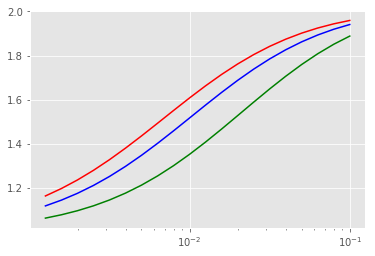

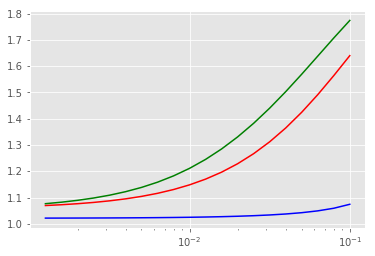

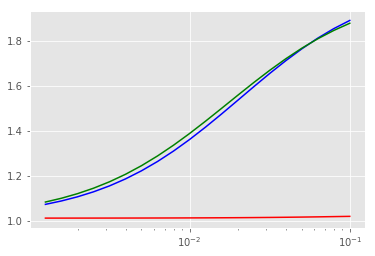

In [16]:
for strain_type in [0,1,2]:
    co_exp = np.real(np.log(co_vals[-1]/co_vals[0])/np.log(reldens[-1]/reldens[0]))+1
    dsch_exp = np.real(np.log(dsch_vals[-1]/dsch_vals[0])/np.log(reldens[-1]/reldens[0]))+1
    psch_exp = np.real(np.log(psch_vals[-1]/psch_vals[0])/np.log(reldens[-1]/reldens[0]))+1
    plt.plot(strains,co_exp.T[strain_type],'r')
    plt.plot(strains,dsch_exp.T[strain_type],'b')
    plt.plot(strains,psch_exp.T[strain_type],'g')
    #plt.axvline(x=0.03,color='g')


    plt.xscale('log')
    plt.show()

0.031622776601683764 [0.05, 0.075, 0.1, 0.15] [0.00321527 0.00536548 0.00762667 0.01240225]


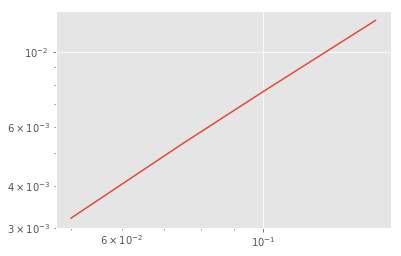

In [17]:
print(strains[5],reldens,np.real(co_vals.T[1][7])*reldens)
plt.plot(reldens, np.real(co_vals.T[1][7])*reldens)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [18]:
(0.0124/0.0323)/(0.15/0.05)

0.12796697626418987

/Users/dcellucc/anaconda3/envs/py37/lib/python3.6/site-packages/numpy-1.15.0-py3.6-macosx-10.7-x86_64.egg/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


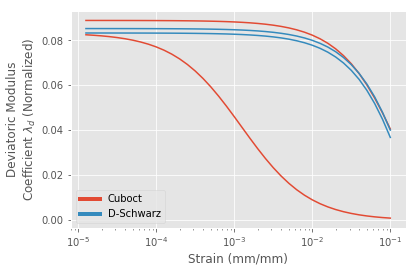

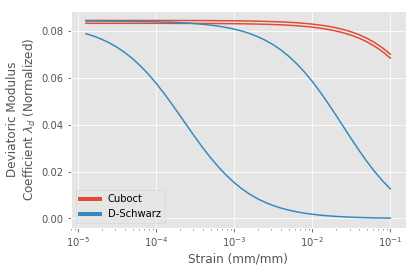

In [61]:

for strain_type in [1,2]:
    custom_lines = []
    l = plt.plot(strains,co_vals[0].T[strain_type],label="{0}".format(reldens[0]))
    custom_lines.append(Line2D([0], [0], color=l[0].get_color(), lw=4))
    for i,co_val in enumerate(co_vals[1:]):
        co_val = np.array(co_val)
        plt.plot(strains,co_val.T[strain_type],label="{0}".format(reldens[i+1]),c=l[0].get_color())
    
    l = plt.plot(strains,dsch_vals[0].T[strain_type])
    custom_lines.append(Line2D([0], [0], color=l[0].get_color(), lw=4))
    for dsch_val in dsch_vals[1:]:
        dsch_val = np.array(dsch_val)
        plt.plot(strains,dsch_val.T[strain_type],l[0].get_color())
    '''   
    l = plt.plot(strains,psch_vals[0].T[strain_type])
    custom_lines.append(Line2D([0], [0], color=l[0].get_color(), lw=4))
    for psch_val in psch_vals[1:]:
        psch_val = np.array(psch_val)
        plt.plot(strains,psch_val.T[strain_type],l[0].get_color())
    '''
    plt.legend(custom_lines, ['Cuboct', 'D-Schwarz'])
    #plt.axvline(x=0.03,color='g')
    plt.xscale('log')
    #plt.xlim([0.008,0.025])
    plt.xlabel("Strain (mm/mm)")
    plt.ylabel("Deviatoric Modulus\nCoefficient $\lambda_d$ (Normalized)")
    
    #plt.yscale('log')
    plt.show()




[[0.08382531 0.80258184]
 [0.09214283 0.95494148]]


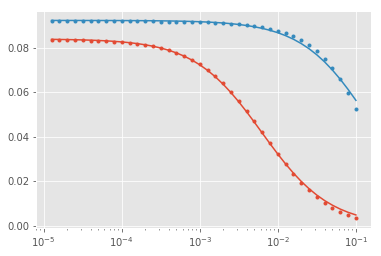

In [71]:
co_strains = np.copy(strains)

log_dsch_strains = np.log(dsch_strains)

dsch_coeff = []

co_reldens = reldens

#dsch_values = np.real(dsch_vals[-1].T[2])

for i,co_val in enumerate(co_vals):
    co_values = np.real(co_val.T[1])

    optimize_func = lambda x: (x[0])/(1+x[1]/co_reldens[i]*np.power(co_strains,1))- co_values  

    #A_0 = 0.083
    K_0 = 0.33
    Q_0 = 1
    #B_0 = 1


    K,Q = leastsq(optimize_func, [K_0,Q_0])[0]
    
    dsch_coeff.append([K,Q])

    l = plt.plot(co_strains,co_values,'.')
    plt.plot(dsch_strains,(K)/(1+Q/co_reldens[i]*np.power(co_strains,1)),c=l[0].get_color())

plt.xscale('log')
#plt.show()
dsch_coeff = np.array(dsch_coeff)

print(dsch_coeff)



# ds = np.arange(0,0.51,0.01)

co_thetas = []
co_strains = []
dsch_strains = []
dsch_thetas = []

for d in ds:
    plane = np.array([0.0,1.0,0.0])
    x1 = np.array([ 0.0  ,0.5-d,0.5+d])
    x2 = np.array([ 0.5+d,0.0  ,0.5-d])
    x3 = np.array([ 1.0  ,-0.5-d,0.5+d])

    norm = np.linalg.norm(x3-x2)
    co_thetas.append(np.arccos(np.dot(x1-x2,x2-x3)/(norm*norm)))
    co_strains.append(norm/(0.5*np.sqrt(2))-1)

    x1 = np.array([0.0,0.5+d,0.5+d])
    x2 = np.array([0.0,1.0,0.0])
    x3 = np.array([0.0,0.0,1.0])
    
    norm = np.linalg.norm(x2-x1)
    dsch_thetas.append(np.pi-np.arccos(np.dot(x1-x2,x1-x3)/(norm*norm)))
    dsch_strains.append(norm/(0.5*np.sqrt(2))-1)

plt.plot(co_thetas,co_strains,'.')
plt.plot(dsch_thetas,dsch_strains,'--')
plt.plot()
plt.xscale('log')
plt.yscale('log')
plt.xlim((0.01,0.5))
#plt.plot(strains, 0.9*np.power(strains,1/3)+np.pi/4)

In [ ]:
offsets = np.power(10,-np.arange(1.15,3,0.1))

offsets = offsets[::-1]


reldens = np.power(10,-np.arange(1,3.5,0.5))

#reldens = [0.1,0.0215,0.00464,0.001]

found_zero = False

co_strains = []

for offset in offsets:
    beamlength = np.sqrt(np.sum(np.power(np.array([0.5+offset,0.5-offset,2*offset])/2,2)))
    co_strains.append(beamlength/(0.5*1/np.sqrt(2))-1)

co_vals = []

for relden in reldens:
    print("RELDEN: {0}".format(relden))
    tvals = []
    found_zero = False
    for offset in offsets:
        if not found_zero:
            beamlength = np.sqrt(np.sum(np.power(np.array([0.5+offset,0.5-offset,2*offset])/2,2)))
            #print((beamlength/(0.5*1/np.sqrt(2))-1))
            co_strain = {'state':co_a1u_self_stress,
                         'mag':0}#(beamlength/(0.5*1/np.sqrt(2))-1)}
            bd, eigens = lattice_stiffness(np.array(gen_co_nodes(offset)),co_frames,1.0,beamlength,relden,CO_B_0,CO_B_a,strain=co_strain)
            #print(eigens[1])
            tvals.append(eigens)
            if eigens[1] <= 0:
                found_zero = True
                print("OFFSET: {0}".format(offset))
        else:
            tvals.append(np.array([0,0,0]))
    co_vals.append(tvals)

co_vals = np.array(co_vals)

In [ ]:
#plt.plot(co_strains, co_vals[0].T[1],label='CO-0.15')
plt.plot(co_strains, co_vals[1].T[0],label='CO-0.1')
#plt.plot(co_strains, co_vals[2].T[1],label='CO-0.07')

plt.plot(co_strains, co_vals[3].T[0],label='CO-0.004')
plt.plot(co_strains, co_vals[4].T[0],label='CO-0.004')
plt.xscale('log')
#plt.xlim((0.0001,0.01))
plt.xlabel("Strain")
plt.ylabel("Deviatoric Stress")


plt.legend()
plt.show()

In [ ]:
offsets = np.power(10,-np.arange(1,4,0.05))
reldens = np.power(10,-np.arange(2,4.5,0.5))


offsets = offsets[::-1]

dsch_strains = []

for offset in offsets:
    beamlength = np.sqrt(2*np.power(0.5+offset,2))
    dsch_strains.append(beamlength/(1/np.sqrt(2))-1)

dsch_vals = []

for relden in reldens:
    tvals = []
    found_zero = False
    for offset in offsets:
        if not found_zero:
            beamlength = beamlength = np.sqrt(2*np.power(0.5+offset,2))
            dsch_strain = {'state':dsch_ss,'mag':0}#(beamlength/(1/np.sqrt(2))-1)}
            bd, eigens = lattice_stiffness(np.array(gen_dsch_nodes(offset)),dsch_frames,1.0,beamlength,relden,fcc_B_0,fcc_B_a,strain=dsch_strain)
            if eigens[2] <= 0:
                found_zero = True
                print(offset)
                tvals.append(np.array([0,0,0]))
            else:
                tvals.append(eigens)

        else:
            tvals.append(np.array([0,0,0]))
    dsch_vals.append(tvals)

dsch_vals = np.array(dsch_vals)

In [ ]:
for dsch_val in dsch_vals:
    plt.plot(dsch_strains, dsch_val.T[0],'--')

plt.xscale('log')
#plt.xlim((0.0001,0.01))
plt.xlabel("Strain")
plt.ylabel("Deviatoric Stress")

#plt.legend()
plt.show()

In [ ]:
offsets = np.power(10,-np.arange(1,4,0.05))
reldens = np.power(10,-np.arange(2,4.5,0.5))


offsets = offsets[::-1]

psch_strains = []

for offset in offsets:
    beamlength = psch_beamlength(offset)
    psch_strains.append(beamlength/psch_beamlength(0)-1)

psch_vals = []

for relden in reldens:
    tvals = []
    found_zero = False
    for offset in offsets:
        if not found_zero:
            beamlength = psch_beamlength(offset)
            #psch_strain = {'state':dsch_ss,'mag':0}#(beamlength/(1/np.sqrt(2))-1)}
            bd, eigens = lattice_stiffness(np.array(gen_psch_nodes(offset)),psch_frames,1.0,beamlength,relden,psch_B_0,psch_B_a)
            if eigens[2] <= 0:
                found_zero = True
                print(offset)
                tvals.append(np.array([0,0,0]))
            else:
                tvals.append(eigens)

        else:
            tvals.append(np.array([0,0,0]))
    psch_vals.append(tvals)

psch_vals = np.array(psch_vals)

In [ ]:
for psch_val in psch_vals:
    plt.plot(psch_strains, psch_val.T[0],'--')

plt.xscale('log')
#plt.xlim((0.0001,0.01))
plt.xlabel("Strain")
plt.ylabel("Deviatoric Stress")

#plt.legend()
plt.show()

In [ ]:
dsch_strains = np.array(dsch_strains)

log_dsch_strains = np.log(dsch_strains)

dsch_coeff = []

dsch_reldens = np.power(10,-np.arange(2,4.5,0.5))

dsch_values = np.real(dsch_vals[2].T[2])
for i,dsch_val in enumerate(dsch_vals):
    dsch_values = np.real(dsch_val.T[0])

    optimize_func = lambda x: (x[0])/(1+x[1]/dsch_reldens[i]*np.power(dsch_strains,x[2]))- dsch_values  

    #A_0 = 0.083
    K_0 = 0.333
    Q_0 = 100
    B_0 = 2


    K,Q,B = leastsq(optimize_func, [K_0,Q_0,B_0])[0]
    
    dsch_coeff.append([K,Q,B])

    l = plt.plot(dsch_strains,dsch_values,'.')
    plt.plot(dsch_strains,(K)/(1+Q/dsch_reldens[i]*np.power(dsch_strains,B)),c=l[0].get_color())

plt.xscale('log')
#plt.show()
dsch_coeff = np.array(dsch_coeff)

psch_strains = np.array(psch_strains)

log_psch_strains = np.log(psch_strains)


psch_coeff = []

psch_reldens = np.power(10,-np.arange(2,4.5,0.5))

psch_values = np.real(psch_vals[2].T[2])
for i,psch_val in enumerate(psch_vals):
    psch_values = np.real(psch_val.T[0])

    optimize_func = lambda x: (x[0])/(1+x[1]/psch_reldens[i]*np.power(psch_strains,x[2]))- psch_values  

    #A_0 = 0.083
    K_0 = 0.333
    Q_0 = 100
    B_0 = 2


    K,Q,B = leastsq(optimize_func, [K_0,Q_0,B_0])[0]
    
    psch_coeff.append([K,Q,B])

    l = plt.plot(psch_strains,psch_values,'.')
    plt.plot(psch_strains,(K)/(1+Q/psch_reldens[i]*np.power(psch_strains,B)),c=l[0].get_color())

plt.xscale('log')
#plt.show()
psch_coeff = np.array(psch_coeff)




co_strains = np.array(co_strains)

log_co_strains = np.log(co_strains)

co_coeff = []

co_reldens = np.power(10,-np.arange(1,3.5,0.5))


for i,co_val in enumerate(co_vals):
    co_values = np.real(co_val.T[0])

    optimize_func = lambda x: (x[0])/(1+x[1]/co_reldens[i]*np.power(co_strains,x[2]))- co_values  

    #A_0 = 0.083
    K_0 = 0.083
    Q_0 = 100
    B_0 = 2


    K, Q, B = leastsq(optimize_func, [K_0, Q_0, B_0])[0]
    
    co_coeff.append([K,Q,B])

    l = plt.plot(co_strains,co_values,'.')
    plt.plot(co_strains,(K)/(1+Q/co_reldens[i]*np.power(co_strains,B)),c=l[0].get_color())
plt.xscale('log')
plt.show()

co_coeff = np.array(co_coeff)

print(dsch_coeff)
print(psch_coeff)
print(co_coeff)

'''
plt.plot(dsch_reldens,dsch_coeff.T[1])
plt.plot(co_reldens,co_coeff.T[1])
plt.xscale('log')
plt.yscale('log')

plt.show()
'''

#full_range_strains = 
#plt.plot(co_strains, co_vals[0].T[0],'r.')
#plt.plot(co_strains, co_vals[-1].T[0],'r.')

In [ ]:
l = plt.plot(psch_strains, psch_vals[0].T[0],'.')
plt.plot(psch_strains, psch_vals[-1].T[0],'.',c=l[0].get_color())
plt.fill_between(psch_strains, 
                 np.real(psch_vals[0].T[0]), 
                 np.real(psch_vals[-1].T[0]), 
                 facecolor=l[0].get_color(),
                 alpha=0.5,
                 interpolate=True,
                 label='P-Schwarz\nCubOct')

l=plt.plot(dsch_strains, dsch_vals[0].T[0],'.')
plt.plot(dsch_strains, dsch_vals[-1].T[0],'.',c=l[0].get_color())
plt.fill_between(dsch_strains, 
                 np.real(dsch_vals[0].T[0]), 
                 np.real(dsch_vals[-1].T[0]), 
                 facecolor=l[0].get_color(),
                 alpha=0.5,
                 interpolate=True,
                 label='D-Schwarz')

plt.xlabel('Macroscopic Strain $\epsilon$')
plt.ylabel('Hydrostatic Stiffness $E_H$')
plt.xscale('log')
plt.legend()
plt.text(0.00007,0.165,'$\propto 1/\epsilon$',size=15)
plt.text(0.004,0.165,'$\propto 1/\epsilon^2$',size=15)
plt.show()

In [ ]:
coeff_list = []
reldens = np.power(10,-np.arange(1,3.5,0.5))

dsch_strains = np.array(dsch_strains)

for i,dsch_val in enumerate(dsch_vals):
    optimize_func = lambda x: x[0]*(x[2]*reldens[i]-dsch_strains)/(x[2]*reldens[i]+dsch_strains)+x[1] - np.real(dsch_val.T[2])   

    guess_amp = 1.0
    guess_mean = 1.0
    guess_freq = 1.0

    est_amp, est_mean,est_freq = leastsq(optimize_func, [guess_amp, guess_mean,guess_freq])[0]

    coeff_list.append([est_amp,est_mean,est_freq])
    
    l = plt.plot(dsch_strains, dsch_val.T[2],'.',label='CO-0.1')
    #plt.plot(dsch_strains, est_amp*(est_freq*reldens[i]-dsch_strains)/(est_freq*reldens[i]+dsch_strains)+est_mean,c=l[0].get_color())
    #a = 0.0175
    #plt.plot(dsch_strains, 0.045*(a-dsch_strains)/(a+dsch_strains)+0.04)

plt.yscale('log')
plt.xscale('log')

coeff_list = np.array(coeff_list)
plt.show()


print(coeff_list)

for coeff_list_vals in coeff_list.T:
    plt.plot(reldens,coeff_list_vals)
    
#plt.xscale('log')
#plt.yscale('log')

plt.show()

In [ ]:
plt.plot(dsch_strains,-np.log(np.real(dsch_vals[3].T[2]/dsch_vals[0].T[2]))/np.log(0.15/0.05)+1)
plt.plot(co_strains,-np.log(np.real(co_vals[3].T[1]/co_vals[0].T[1]))/np.log(0.15/0.05)+1)

plt.xscale('log')
plt.xlabel("Strain")
plt.ylabel("DSchwarz Scaling")

In [ ]:
thetas = np.arange(0.55,np.pi/4-0.01,0.01)
thetas = thetas[::-1]
reldens = [0.15,0.1,0.07,0.05]

kel_strains = []

for theta in thetas:
    unit_cell_size = (np.sin(theta)+np.cos(theta))/np.sqrt(2)
    kel_strains.append((1./unit_cell_size-1))

print(kel_strains)
    
kel_vals = []

for i,rel_den in enumerate(reldens):
    tvals = []

    for theta in thetas:
        beamlength = 1/(2*np.sqrt(2))
        unit_cell_size = (np.sin(theta)+np.cos(theta))/np.sqrt(2)
        kel_nodes = np.array(gen_kel_nodes(theta))
        bd,vals = lattice_stiffness(kel_nodes,kelvin_frames,unit_cell_size,beamlength,rel_den,kel_B_0,kel_B_a)
        tvals.append(vals)
    kel_vals.append(tvals)

kel_vals = np.array(kel_vals)

plt.plot(kel_strains, kel_vals[0].T[2],'--',label='DS-0.15')
plt.plot(kel_strains, kel_vals[1].T[2],'--',label='DS-0.1')
plt.plot(kel_strains, kel_vals[2].T[2],'--',label='DS-0.07')
plt.plot(kel_strains, kel_vals[3].T[2],'--',label='DS-0.05')
plt.xscale('log')

In [ ]:
plt.plot(co_strains,-np.log(np.real(co_vals[3].T[1]/co_vals[0].T[1]))/np.log(0.15/0.05)+1)
plt.xscale('log')
plt.xlabel("Strain")
plt.ylabel("Cuboct Scaling")

In [ ]:
fig = plt.figure(figsize=(6.4,4.8))

p0 = plt.plot(dsch_strains, dsch_vals[0].T[1],label='DS-0.15')
p1 = plt.plot(dsch_strains, dsch_vals[1].T[1],label='DS-0.1')
#p2 = plt.plot(dsch_strains, dsch_vals[2].T[2],label='DS-0.07')
p3 = plt.plot(dsch_strains, dsch_vals[3].T[1],label='DS-0.05')

plt.plot(co_strains, co_vals[0].T[1],'--',label='CO-0.15',color=p0[0].get_color())
plt.plot(co_strains, co_vals[1].T[1],'--',label='CO-0.10',color=p1[0].get_color())
#plt.plot(co_strains, co_vals[2].T[1],'--',label='CO-0.07',color=p2[0].get_color())
plt.plot(co_strains, co_vals[3].T[1],'--',label='CO-0.05',color=p3[0].get_color())

plt.plot(kel_strains, kel_vals[0].T[1],'-.',label='kel-0.15',color=p0[0].get_color())
plt.plot(kel_strains, kel_vals[1].T[1],'-.',label='kel-0.10',color=p1[0].get_color())
#plt.plot(kel_strains, kel_vals[2].T[1],'-.',label='kel-0.07',color=p2[0].get_color())
plt.plot(kel_strains, kel_vals[3].T[1],'-.',label='kel-0.05',color=p3[0].get_color())

plt.xscale('log')
#plt.xlim((0.0001,0.01))
plt.xlabel("Strain")
plt.ylabel("Deviatoric Stress")
plt.xlim((0.001,0.03))
plt.ylim((0.0,0.095))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



In [ ]:
y = [0.0022387211385683447,
0.0015848931924611288,
0.0012302687708124,
0.0009332543007970106]

y2 = [0.005011872336272719,
0.003162277660168376,
0.0019952623149688768,
0.0012589254117941649]

x = [0.15,0.1,0.07,0.05]

plt.plot(x,y,'--')
plt.plot(x,y2)
plt.xscale('log')
plt.yscale('log')

np.polyfit(np.log(x),np.log(y),1)
np.polyfit(np.log(x),np.log(y2),1)

<img src="media/FCC_Lattices.PNG" alt="drawing"/>


In [ ]:
unitcell_dims = 1.0
beamlength = unitcell_dims/(2*np.sqrt(2))
E_mat = 1.0
rho_mat = 0 #2.0
nu_mat = 0 #0.3

frame_props = {'E'   : E_mat,
               'rho' : rho_mat,
               'nu'  : nu_mat,
    'cross_section'  : 'circular',
               'roll': 0,
              'loads':{'element':0},
        'prestresses':{'element':0},
                 'Le': beamlength,
     'beam_divisions': 1,
              'shear': False,
       'pin-jointed' : False}

offsets = []
reldens = [0.1,0.01,0.001,0.0001]

offsets_row = np.power(10,-np.arange(1,3.8,0.1))
thetas_row = np.arange(0.2,np.pi/4,0.01)
dsch_strains = []
dsch_kvals = []
kel_kvals = []
kel_strains = []

for i,rel_den in enumerate(reldens):
    dsch_strains.append([])
    dsch_kvals.append([])
    kel_kvals.append([])
    kel_strains.append([])
    for j,offset in enumerate(offsets_row):
        dsch_nodes = np.array(gen_dsch_nodes(offset))
        beamlength = np.sqrt(2*np.power(0.5+offset,2))
        bd, vals = lattice_stiffness(dsch_nodes,dsch_frames,unitcell_dims,beamlength,rel_den,fcc_B_0,fcc_B_a)
        dsch_kvals[i].append(vals)
        dsch_strains[i].append(beamlength/(0.5*np.sqrt(2)))
    beamlength = 1/(2*np.sqrt(2))
    for theta in thetas_row:
        unit_cell_size = (np.sin(theta)+np.cos(theta))/np.sqrt(2)
        kel_nodes = np.array(gen_kel_nodes(theta))
        bd,vals = lattice_stiffness(kel_nodes,kelvin_frames,unit_cell_size,beamlength,rel_den,kel_B_0,kel_B_a)
        kel_kvals[i].append(vals)
        kel_strains[i].append((1./unit_cell_size-1)*100)
        

In [ ]:
f = plt.gcf()
f.set_size_inches(6, 4)
lines = []
for i in range(len(dsch_kvals)):
    lines.append(plt.plot((np.array(dsch_strains[i])-1)*100,np.array(dsch_kvals)[i].T[2],label="p*={0}".format(reldens[i])))

for i in range(len(kel_kvals)):
    plt.plot(kel_strains[i],np.array(kel_kvals)[i].T[2],linestyle='--',color=lines[i][0].get_color())

    
plt.legend()
#plt.title('Stability of the Infinitesimal Mechanism Mode in D-Schwarz')
plt.ylabel('Shear Modulus Coefficient')
plt.xlabel('Macroscopic Strain (%)')
plt.xscale('log')
plt.yscale('log')
plt.xlim((0.04,30))
#plt.text(0.04,0.03,"Linear Scaling\nRegime")
#plt.text(2.2,0.002,"Quadratic Scaling Regime",rotation=-50)
plt.savefig("DSCH_SM_scaling.pdf")
plt.show()